# Klachten Dataset Project 1
## Data Voorbereiding 
Versie Mattijn

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from pathlib import Path
from typing import Dict, List, Tuple

from sklearn import tree
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    mean_absolute_error,
    r2_score,
    root_mean_squared_error,
)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from wordcloud import WordCloud


In [2]:
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt_tab: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading omw-1.4: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [3]:
klachten = pd.read_csv("klachten.csv")

In [4]:
klachten = klachten.drop(columns="ID")
klachten = klachten.drop(columns="Antwoord_bedrijf")

In [5]:
klachten.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14887 entries, 0 to 14886
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Datum_ontvangst  14887 non-null  object
 1   Product          14887 non-null  object
 2   Omschrijving     14887 non-null  object
dtypes: object(3)
memory usage: 349.0+ KB


## Train-Test Splits maken

In [6]:
X = klachten["Omschrijving"].astype(str)
y = klachten["Product"].astype(str)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(10420,) (4467,)
(10420,) (4467,)


In [7]:
X_train.to_csv("xtrain.csv")
y_train.to_csv("ytrain.csv")

X_test.to_csv("xtest.csv")
y_test.to_csv("ytest.csv")

## Data Processing

#### Stopwords

In [6]:
stop_words = set(stopwords.words("english"))

# FIXED: je miste komma’s → Python plakt ze dan aan elkaar!
extra_stopwords = {
    "well", "way", "said", "see", "say", "n",
    "need", "going", "got", "s", "n't", "told",
    "u", "help", "call", "got", "still", "still",
    "either", "trying", "tell", "use", "gave", "fact"
}

stop_words |= extra_stopwords   # union

In [7]:
lemmatizer = WordNetLemmatizer()

def remove_punctuation(text: str) -> str:
    return re.sub(r"[^\w\s]", "", text)

def has_multiple_x(word: str) -> bool:
    """Filter woorden met meer dan 1 'x' (case-insensitive)."""
    return word.lower().count("x") > 1

def data_preprocessor(text: str) -> str:
    text = text.lower()
    text = remove_punctuation(text)
    return text

def data_tokenizer(text: str):
    tokens = word_tokenize(text)

    tokens = [
        t for t in tokens
        if t not in stop_words
        and not has_multiple_x(t)
        and len(t) > 2                # korte troep verwijderen
        and not t.isdigit()           # cijfers eruit
    ]

    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

In [8]:
with open("stopwords.txt", "w", encoding="utf-8") as f:
    for word in sorted(stop_words):      # sorted = mooi alfabetisch
        f.write(word + "\n")


In [9]:
vectorizer = TfidfVectorizer(
    lowercase=False,
    preprocessor=data_preprocessor,
    tokenizer=data_tokenizer,
    analyzer="word",
    stop_words=None,
    token_pattern=None
)

X_train_tfidf = vectorizer.fit_transform(X_train)

print("\nVorm van de TF-IDF-matrix:", X_train_tfidf.shape)
print("Features (woorden):", vectorizer.get_feature_names_out())


Vorm van de TF-IDF-matrix: (10420, 19264)
Features (woorden): ['000interest' '0date' '0monthly' ... 'zone' 'zoning' 'zwicker']


### Datum exploration Grafiek

In [10]:
klachten["Datum_ontvangst"] = pd.to_datetime(klachten["Datum_ontvangst"])


Aantal klachten per dag

In [11]:
per_dag = (
    klachten
    .set_index("Datum_ontvangst") 
    .resample("D")                 
    .size()                        
    .rename("aantal_klachten")
    .reset_index()
)

Grafieken met de data

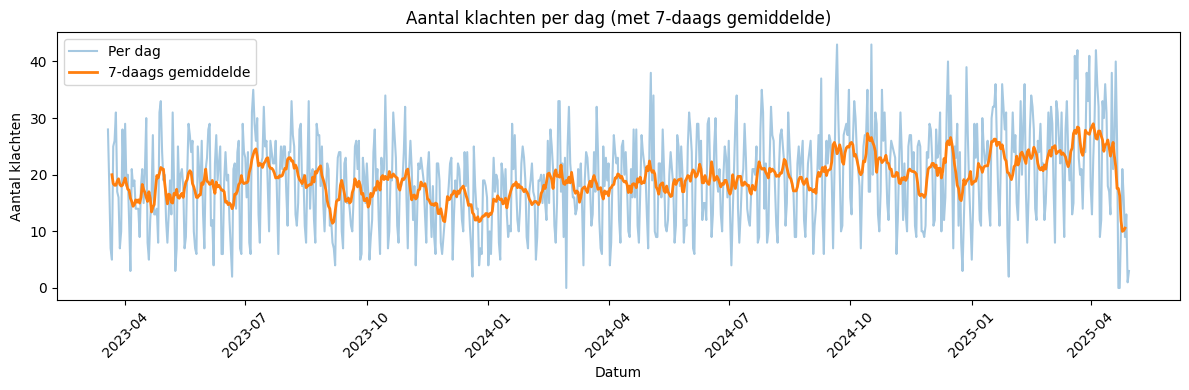

In [12]:
per_dag["rolling_7"] = per_dag["aantal_klachten"].rolling(7, center=True).mean()

plt.figure(figsize=(12, 4))
plt.plot(per_dag["Datum_ontvangst"], per_dag["aantal_klachten"], alpha=0.4, label="Per dag")
plt.plot(per_dag["Datum_ontvangst"], per_dag["rolling_7"], linewidth=2, label="7-daags gemiddelde")
plt.title("Aantal klachten per dag (met 7-daags gemiddelde)")
plt.xlabel("Datum")
plt.ylabel("Aantal klachten")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

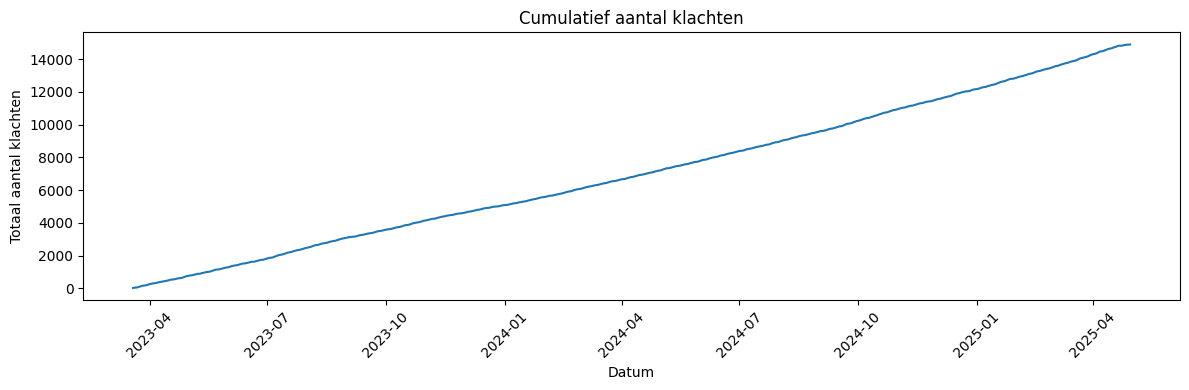

In [13]:
per_dag["cumulatief"] = per_dag["aantal_klachten"].cumsum()

plt.figure(figsize=(12, 4))
plt.plot(per_dag["Datum_ontvangst"], per_dag["cumulatief"])
plt.title("Cumulatief aantal klachten")
plt.xlabel("Datum")
plt.ylabel("Totaal aantal klachten")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


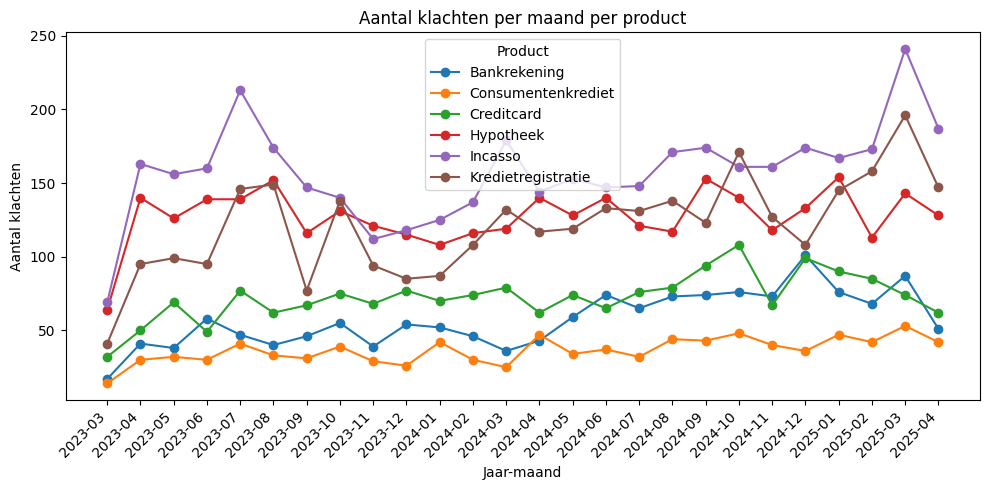

In [14]:
klachten["jaar"] = klachten["Datum_ontvangst"].dt.year
klachten["maand"] = klachten["Datum_ontvangst"].dt.month

per_maand_product = (
    klachten
    .groupby(["jaar", "maand", "Product"])
    .size()
    .rename("aantal_klachten")
    .reset_index()
)

per_maand_product["jaar_maand"] = (
    per_maand_product["jaar"].astype(str) + "-" +
    per_maand_product["maand"].astype(str).str.zfill(2)
)


plt.figure(figsize=(10,5))

for product, subdf in per_maand_product.groupby("Product"):
    plt.plot(subdf["jaar_maand"], subdf["aantal_klachten"], marker="o", label=product)

plt.title("Aantal klachten per maand per product")
plt.xlabel("Jaar-maand")
plt.ylabel("Aantal klachten")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Product")
plt.tight_layout()
plt.show()

In [15]:
klachten.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14887 entries, 0 to 14886
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID                14887 non-null  int64         
 1   Datum_ontvangst   14887 non-null  datetime64[ns]
 2   Product           14887 non-null  object        
 3   Omschrijving      14887 non-null  object        
 4   Antwoord_bedrijf  14887 non-null  object        
 5   jaar              14887 non-null  int32         
 6   maand             14887 non-null  int32         
dtypes: datetime64[ns](1), int32(2), int64(1), object(3)
memory usage: 698.0+ KB


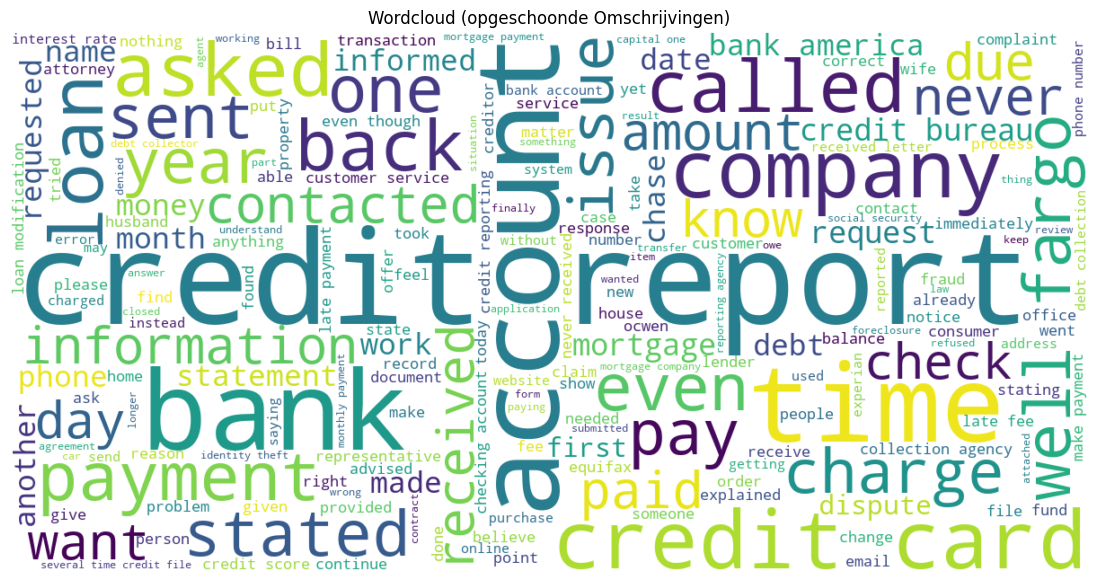

In [16]:
all_tokens = []

for text in klachten["Omschrijving"].astype(str):
    clean = data_preprocessor(text)
    tokens = data_tokenizer(clean)
    all_tokens.extend(tokens)

clean_text = " ".join(all_tokens)

wc = WordCloud(
    background_color="white",
    max_words=200,
    width=1200,
    height=600
).generate(clean_text)

plt.figure(figsize=(14,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud (opgeschoonde Omschrijvingen)")
plt.show()